In [82]:
import pandas as pd
import numpy as np
import pip
import os
from tqdm.notebook import tqdm, trange
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    __import__("xarray")
except ImportError:
    pip.main(['install', "xarray"])

import xarray as xr
pd.options.display.max_columns = None
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.transform import factor_cmap, factor_mark

# Investigating Relationship Between Weather and Criminal Offense Trends in New Orleans

### Hayden Outlaw, Joe Wagner | [Tulane CMPS 6790 Data Science](https://nmattei.github.io/cmps6790/) | Fall 2023

### https://outlawhayden.github.io/weather-crime




## Project Outline

In our project, we aim to investigate the intriguing relationship between weather patterns, particularly hotter temperatures, and crime rates. By leveraging NOAA datasets encompassing historical weather data and NOLA.gov open crime datasets, our objective is to discern patterns and correlations that may exist between these two variables. The hypothesis under scrutiny is whether hotter temperatures act as a catalyst for an increase in criminal activities. This hypothesis is by no means a novel question to study - scholars have tried to explain the association between climate and crime as far back as [Hippocrates 2,400 years ago](https://criminal-justice.iresearchnet.com/correlates-of-crime/weather-and-crime/#:~:text=Of%20all%20of%20the%20weather,increasing%20during%20the%20summer%20months.)! While no proven causation has been found to this day, the first explanations argued that climate affected our biology leading to higher crime rates, which has since been disproven by researchers. Recently, research regarding weather and crime has ramped up due to the computing power and dataset size that we now have at our disposal. The majority of current studies have found a positive, linear association between temperature and violent crime rates according to [Cohn](https://academic.oup.com/bjc/article-abstract/30/1/51/523870?redirectedFrom=fulltext&login=false). We hope to also find this positive, linear correlation among the crime and weather data in New Orleans over the past decade. Ultimately, we hope to evince the historical weather-crime association within our own community to create a better understanding of the violent crime rates that, in 2022, led to New Orleans having the [most murders per capita](https://wirepoints.org/chicago-new-orleans-were-the-nations-murder-capitals-in-2022-a-wirepoints-survey-of-americas-75-largest-cities/#:~:text=This%20report%27s%20key%20findings%20include,rounded%20out%20the%20top%205.).

## Collaboration Plan
To collaborate, we intend to utilize two primary tools. The first is a Github Repository, which will handle code sharing, versioning control, organization, and publication. All of our code, tools, and assets are publicly available here: [GITHUB REPOSITORY](https://github.com/outlawhayden/weather-crime) 

For live programming collaboration, we intend to use [Visual Studio Code Live Share](https://code.visualstudio.com/learn/collaboration/live-share) which allows for live simultaneous code editing. We also intend to meet twice a week in person to commit to broader project planning and directional goals.

## New Orleans Police Department Calls for Service
-------
The first half of data that we require to investigate this relationship is crime data from New Orleans. [Data Driven NOLA](https://datadriven.nola.gov/home/) hosts publications of all New Orleans Police Department calls for service from 2011 to the present. The data is sanitized of any personal identifiers, but contains location, time, priority, and incident type information. Each year is hosted separately - and cumulatively, the dataset is too large for us to host. The manual download sources are below:

- [2011 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2011/28ec-c8d6)
- [2012 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2012/rv3g-ypg7)
- [2013 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2013/5fn8-vtui)
- [2014 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2014/jsyu-nz5r)
- [2015 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2015/w68y-xmk6)
- [2016 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2016/wgrp-d3ma)
- [2017 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2017/bqmt-f3jk)
- [2018 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2018/9san-ivhk)
- [2019 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2019/qf6q-pp4b)
- [2020 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Call-for-Service-2020/hp7u-i9hf)
- [2021 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2021/3pha-hum9)
- [2022 Calls for Service](https://data.nola.gov/browse/?q=Calls%20for%20Service%202022&sortBy=relevance)
- [2023 Calls for Service](https://data.nola.gov/Public-Safety-and-Preparedness/Calls-for-Service-2023/pc5d-tvaw)

To download the data, go to Export -> CSV.

The following script takes all of the .csv files in the folder location `data_folder`, and stitches them together into one large dataframe to be cached as `calls_master.csv` and then loaded. To load the data, save all of the exported spreadsheets as .csv files into the location of `data_folder`, and then run the cell.

In [138]:
data_folder = '../data/calls_for_service'
csv_files = [f for f in os.listdir(data_folder) if f.endswith('csv')]
if 'calls_master.csv' not in csv_files:
    calls_for_service = pd.DataFrame()

    for f in tqdm(csv_files, desc = "Combining Files"):
        file_path = os.path.join(data_folder, f)
        df = pd.read_csv(file_path)
        calls_for_service = pd.concat([calls_for_service, df], ignore_index = True)
    calls_for_service.to_csv('../data/calls_for_service/calls_master.csv')
else:
    calls_for_service = pd.read_csv(os.path.join(data_folder, 'calls_master.csv'))


/var/folders/vh/j0_lsnhd1_d199g2tx8chgx00000gp/T/ipykernel_14327/1605629851.py:12: DtypeWarning: Columns (2,5,6,7,12,16,17,22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  calls_for_service = pd.read_csv(os.path.join(data_folder, 'calls_master.csv'))


In [140]:
calls_for_service.head()

,Unnamed: 0,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,Type_,TimeArrival
0,0,A3472220,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3688756.0,528696.0,01/28/2020 01:37:20 AM,01/28/2020 01:37:20 AM,01/28/2020 01:37:28 AM,01/28/2020 02:25:50 AM,NAT,Necessary Action Taken,N,4G04,Atlantic Ave & Slidell St,70114.0,4,POINT (-90.04525645 29.94750953),NaN,NaN
1,1,A0000220,21,COMPLAINT OTHER,1J,21,COMPLAINT OTHER,1J,3668710.0,533007.0,01/01/2020 12:00:42 AM,01/01/2020 12:00:42 AM,01/01/2020 12:00:42 AM,01/01/2020 01:37:16 AM,NAT,Necessary Action Taken,Y,2U04,034XX Broadway St,70125.0,2,POINT (-90.10840522 29.95996774),NaN,NaN
2,2,A2190820,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3682445.0,530709.0,01/17/2020 09:18:41 PM,01/17/2020 09:18:41 PM,01/17/2020 09:18:47 PM,01/17/2020 09:18:54 PM,NAT,Necessary Action Taken,N,8B02,N Peters St & Bienville St,70130.0,8,POINT (-90.065113 29.95323762),NaN,NaN
3,3,A2874820,21,COMPLAINT OTHER,2A,21,COMPLAINT OTHER,1J,3737616.0,590067.0,01/23/2020 10:19:48 AM,01/23/2020 10:22:05 AM,01/23/2020 10:31:11 AM,01/23/2020 10:34:35 AM,GOA,GONE ON ARRIVAL,N,7L08,I-10 E,70129.0,7,POINT (-89.88854843 30.11465463),NaN,NaN
4,4,A2029120,34S,AGGRAVATED BATTERY BY SHOOTING,2C,34S,AGGRAVATED BATTERY BY SHOOTING,2C,3696210.0,551411.0,01/16/2020 05:09:05 PM,01/16/2020 05:09:43 PM,01/16/2020 05:16:07 PM,01/16/2020 10:49:37 PM,RTF,REPORT TO FOLLOW,N,7A01,Chef Menteur Hwy & Downman Rd,70126.0,7,POINT (-90.02090137 30.00973449),NaN,NaN


According to Data Driven NOLA, the default attributes are described as:
- **NOPD_Item**: The NOPD unique item number for the incident.
- **Type**: The NOPD Type associated with the call for service.
- **TypeText**: The NOPD TypeText associated with the call for service.
- **Priority**: The NOPD Priority associated with the call for service. Code 3 is considered the highest priority and is reserved for officer needs assistance. Code 2 are considered "emergency" calls for service. Code 1 are considered "non-emergency" calls for service. Code 0 calls do not require a police presence. Priorities are differentiated further using the letter designation with "A" being the highest priority within that level.
- **InitialType**: The NOPD InitialType associated with the call for service.
- **InitialTypeText**: The NOPD InitialTypeText associated with the call for service.
- **InitialPriority**: The NOPD InitialPriority associated with the call for service. See Priority description for more information.
- **MapX**: The NOPD MapX associated with the call for service. This is provided in state plane and obscured to protect the sensitivity of the data.
- **MapY**: The NOPD MapY associated with the call for service. This is provided in state plane and obscured to protect the sensitivity of the data.
- **TimeCreate**: The NOPD TimeCreate associated with the call for service. This is the time stamp of the create time of the incident in the CAD system.
- **TimeDispatch**: The NOPD TimeDispatch associated with the call for service. This is the entered time by OPCD or NOPD when an officer was dispatched. 
- **TimeArrive**: The NOPD TimeArrive associated with the call for service. This is the entered time by OPCD or NOPD when an officer arrived.
- **TimeClosed**: The NOPD TimeClosed associated with the call for service. This is the time stamp of the time the call was closed in the CAD system.
- **Disposition**: The NOPD Disposition associated with the call for service.
- **DispositionText**: The NOPD DispositionText associated with the call for service.
- **SelfInitiated**: The NOPD SelfInitiated associated with the call for service. A call is considered self-initiated if the Officer generates the item in the field as opposed to responding to a 911 call.
- **Beat**: The NOPD Beat associated with the call for service. This is the area within Orleans Parish that the call for service occurred. The first number is the NOPD District, the letter is the zone, and the numbers are the subzone.
- **BLOCK_ADDRESS**: The BLOCK unique address number for the incident. The block address has been obscured to protect the sensitivity of the data.
- **Zip**: The NOPD Zip associated with the call for service.
- **PoliceDistrict**: The NOPD PoliceDistrict associated with the call for service.
- **Location**: The NOPD Location associated with the call for service. The X,Y coordinates for the call for service obscured to protect the sensitivity of the data.


The dataset is large, with more than 5000000 rows.


In [85]:
calls_for_service.shape

(5109233, 24)

By examining the `TypeText` attribute, we can see a few of the unique incident types reported in the dataset.

In [135]:
calls_for_service["TypeText"].unique()[:50]

array(['AREA CHECK', 'COMPLAINT OTHER', 'AGGRAVATED BATTERY BY SHOOTING',
       'AUTO ACCIDENT', 'RECOVERY OF REPORTED STOLEN VEHICLE',
       'DISTURBANCE (OTHER)', 'SHOPLIFTING', 'BICYCLE THEFT', 'HIT & RUN',
       'TRAFFIC STOP', 'BURGLAR ALARM, SILENT', 'DISCHARGING FIREARM',
       'SIMPLE BURGLARY VEHICLE', 'MEDICAL', 'SUSPICIOUS PERSON',
       'DOMESTIC DISTURBANCE', 'FIREWORKS', 'MENTAL PATIENT',
       'SUICIDE THREAT', 'PROWLER', 'FIGHT', 'THEFT',
       'SIMPLE CRIMINAL DAMAGE', 'EXTORTION (THREATS)', 'THEFT BY FRAUD',
       'SIMPLE BATTERY', 'RESIDENCE BURGLARY', 'HOMICIDE BY SHOOTING',
       'MISSING JUVENILE', 'RETURN FOR ADDITIONAL INFO',
       'UNAUTHORIZED USE OF VEHICLE', 'LOST PROPERTY',
       'VIOLATION OF PROTECTION ORDER', 'PUBLIC GATHERING',
       'AGGRAVATED RAPE', 'UNCLASSIFIED DEATH',
       'AGGRAVATED ASSAULT DOMESTIC', 'AUTO THEFT', 'TRAFFIC INCIDENT',
       'SIMPLE BATTERY DOMESTIC', 'DRUG VIOLATIONS',
       'SIMPLE ASSAULT DOMESTIC', 'THEFT FROM

## NOAA Weather Station Data
-------
The second data requirement to answer this question is weather data from around New Orleans across time. The National Oceanic and Atmospheric Administration maintains the [Climate Data Online Service](https://www.ncei.noaa.gov/cdo-web/), which allows for requests of historical data from federal weather stations across the country. Our target dataset is the Global Historical Cliamte Network Daily, which includes daily land surface observations around the world of temperature, precipitation, wind speed, and other attributes. While there is no direct way to immediately download the data from NOAA, they do allow for public requests via email which include a source from which to download the results of the query.

![GHCN-Daily Query](https://raw.githubusercontent.com/outlawhayden/weather-crime/main/assets/NCEI_Reciept.png)

For this project, there are 11 different weather stations with archived data from Jan 1 2011 to the date of the query (Sept 29 2023). 

![GHCN-Station Maps](https://raw.githubusercontent.com/outlawhayden/weather-crime/main/assets/NCIS_map.png)

Some of the stations are renamings of existing stations, so there are eight unique locations that the weather data comes from. With this information, given a crime location and time, we can match it to the weather data from the nearest station with data at that point geographically, and establish what the weather was when it occurred.

The results of the query for this project specifically are small enough for us to host. To download them, they are available as a part of this project's repository [HERE](https://github.com/outlawhayden/weather-crime/blob/main/data/weather/NCEI_CDO.csv)

In [87]:
weather = pd.read_csv('../data/weather/NCEI_CDO.csv', low_memory = False)

In [88]:
weather.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,AWND_ATTRIBUTES,DAPR,DAPR_ATTRIBUTES,FMTM,FMTM_ATTRIBUTES,MDPR,MDPR_ATTRIBUTES,PGTM,PGTM_ATTRIBUTES,PRCP,PRCP_ATTRIBUTES,SNOW,SNOW_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES,TOBS,TOBS_ATTRIBUTES,WDF2,WDF2_ATTRIBUTES,WDF5,WDF5_ATTRIBUTES,WSF2,WSF2_ATTRIBUTES,WSF5,WSF5_ATTRIBUTES,WT01,WT01_ATTRIBUTES,WT02,WT02_ATTRIBUTES,WT03,WT03_ATTRIBUTES,WT04,WT04_ATTRIBUTES,WT05,WT05_ATTRIBUTES,WT06,WT06_ATTRIBUTES,WT08,WT08_ATTRIBUTES,WT10,WT10_ATTRIBUTES,WT11,WT11_ATTRIBUTES,WT13,WT13_ATTRIBUTES,WT14,WT14_ATTRIBUTES,WT16,WT16_ATTRIBUTES,WT18,WT18_ATTRIBUTES,WT21,WT21_ATTRIBUTES
0,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.03,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.04,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,"T,,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.50,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,US1LAOR0006,"NEW ORLEANS 2.1 ENE, LA US",29.961679,-90.038803,2.4,2015-02-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.59,",,N",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Tidying Calls for Service Dataframe

First, we drop some unneccessary columns and then make sure each variable has the correct data type

In [91]:
calls_for_service.dtypes

Unnamed: 0           int64
NOPD_Item           object
Type                object
TypeText            object
Priority            object
InitialType         object
InitialTypeText     object
InitialPriority     object
MapX               float64
MapY               float64
TimeCreate          object
TimeDispatch        object
TimeArrive          object
TimeClosed          object
Disposition         object
DispositionText     object
SelfInitiated       object
Beat                object
BLOCK_ADDRESS       object
Zip                float64
PoliceDistrict       int64
Location            object
Type_               object
TimeArrival         object
dtype: object

In [92]:
calls_for_service['Zip'] = calls_for_service['Zip'].astype(str)

In [93]:
calls_for_service['TimeCreate'] = pd.to_datetime(calls_for_service['TimeCreate'])
calls_for_service['TimeDispatch'] = pd.to_datetime(calls_for_service['TimeDispatch'])
calls_for_service['TimeArrive'] = pd.to_datetime(calls_for_service['TimeArrive'])
calls_for_service['TimeClosed'] = pd.to_datetime(calls_for_service['TimeClosed'])

In [94]:
calls_for_service.drop(['Unnamed: 0'], axis =1, inplace = True)

In [95]:
calls_for_service.head()

,NOPD_Item,Type,TypeText,Priority,InitialType,InitialTypeText,InitialPriority,MapX,MapY,TimeCreate,TimeDispatch,TimeArrive,TimeClosed,Disposition,DispositionText,SelfInitiated,Beat,BLOCK_ADDRESS,Zip,PoliceDistrict,Location,Type_,TimeArrival
0,A3472220,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3688756.0,528696.0,2020-01-28 01:37:20,2020-01-28 01:37:20,2020-01-28 01:37:28,2020-01-28 02:25:50,NAT,Necessary Action Taken,N,4G04,Atlantic Ave & Slidell St,70114.0,4,POINT (-90.04525645 29.94750953),NaN,NaN
1,A0000220,21,COMPLAINT OTHER,1J,21,COMPLAINT OTHER,1J,3668710.0,533007.0,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 00:00:42,2020-01-01 01:37:16,NAT,Necessary Action Taken,Y,2U04,034XX Broadway St,70125.0,2,POINT (-90.10840522 29.95996774),NaN,NaN
2,A2190820,22A,AREA CHECK,1K,22A,AREA CHECK,1K,3682445.0,530709.0,2020-01-17 21:18:41,2020-01-17 21:18:41,2020-01-17 21:18:47,2020-01-17 21:18:54,NAT,Necessary Action Taken,N,8B02,N Peters St & Bienville St,70130.0,8,POINT (-90.065113 29.95323762),NaN,NaN
3,A2874820,21,COMPLAINT OTHER,2A,21,COMPLAINT OTHER,1J,3737616.0,590067.0,2020-01-23 10:19:48,2020-01-23 10:22:05,2020-01-23 10:31:11,2020-01-23 10:34:35,GOA,GONE ON ARRIVAL,N,7L08,I-10 E,70129.0,7,POINT (-89.88854843 30.11465463),NaN,NaN
4,A2029120,34S,AGGRAVATED BATTERY BY SHOOTING,2C,34S,AGGRAVATED BATTERY BY SHOOTING,2C,3696210.0,551411.0,2020-01-16 17:09:05,2020-01-16 17:09:43,2020-01-16 17:16:07,2020-01-16 22:49:37,RTF,REPORT TO FOLLOW,N,7A01,Chef Menteur Hwy & Downman Rd,70126.0,7,POINT (-90.02090137 30.00973449),NaN,NaN


## EDA

Let's take a look at some firework related 911 calls. Before plotting, we would expect there to be an influx on certain days of the year (NYE, July 4). We can extract just the type of offense, and the time from the master dataframe.

In [96]:
explosions_df = calls_for_service[["TypeText", "TimeCreate"]].copy()[calls_for_service["TypeText"].str.contains('FIRE BOMB|EXPLOSION|FIREWORKS|ILLEGAL FIREWORKS')]

In [97]:
explosions_df["TypeText"].value_counts()

TypeText
FIREWORKS            5249
ILLEGAL FIREWORKS     169
EXPLOSION              42
FIRE BOMB               1
Name: count, dtype: int64

From this data, 5249 incdents involved fireworks, 169 involved illegal fireworks, 42 involved explosions, and 1 involved a fire bomb. However, we want to see how many of each kind of incident occur on each day and month, independent of the time, or the year. We can do this by extracting just the month and day of the incident from the datetime object. 

In [98]:
explosions_df["Date"] = explosions_df["TimeCreate"].dt.strftime('%m-%d')
explosions_df.head()

,TypeText,TimeCreate,Date
26,FIREWORKS,2020-01-01 00:00:34,01-01
27,FIREWORKS,2020-01-01 00:01:05,01-01
2502,FIREWORKS,2020-01-01 00:03:46,01-01
2503,FIREWORKS,2020-01-01 00:03:52,01-01
4494,FIREWORKS,2020-04-20 20:22:27,04-20


Since we care about the date, the type of incident, and the quantity of ocurrence, let's group the data by the date of occurrence and then within by the type of incident. We can reindex by these two attributes and then examine their relationship to the quantity.

In [104]:
explosions_nested_df = pd.DataFrame(explosions_df.groupby(["Date", "TypeText"])["TypeText"].count())
explosions_nested_df.rename(columns = {"Date" : "Date", "TypeText": "TypeText", "TypeText": "Quantity"}, inplace = True)
explosions_nested_df.head()

Quantity
Date  TypeText                   
01-01 FIREWORKS               720
      ILLEGAL FIREWORKS        29
01-02 FIREWORKS                81
      ILLEGAL FIREWORKS         3
01-03 FIREWORKS                44

Which day had the most incidents?

In [106]:
print("Maximum Incidents on", explosions_nested_df["Quantity"].idxmax()[0])
print("Maximum Number of Incidents is", explosions_nested_df["Quantity"].max())

Maximum Incidents on 07-04
Maximum Number of Incidents is 1160


Unsuprisingly, the most occur on the Fourth of July, which lines up with our expectations. Let's make a plot to examine the frequency of explosive incedents throughout the year, and see if there are other patterns to be seen.

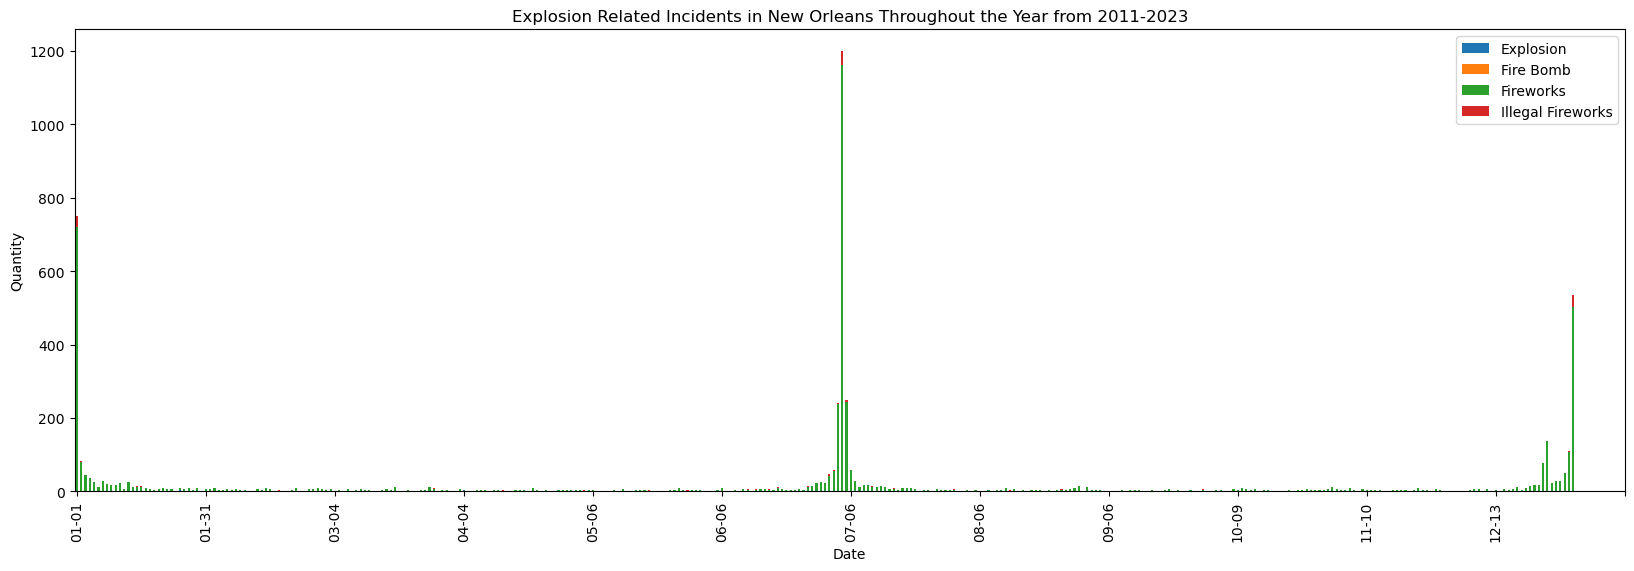

In [110]:
ax = explosions_nested_df.unstack().plot(kind = "bar", stacked = True, figsize = (20,6))
xtick_interval = 30
ax.set_xticks(range(0, 365, xtick_interval));
ax.set_ylabel("Quantity")
ax.set_title("Explosion Related Incidents in New Orleans Throughout the Year from 2011-2023")
ax.legend(["Explosion", "Fire Bomb", "Fireworks", "Illegal Fireworks"]);

While there is a dramatic spike around the fourth of July, there is also noticeable additional activity around Christmas and New Years. Other than that, explosion related incedents are relatively rare throughout the rest of the year. While this pattern of activity is seasonal and shows a clear temporal pattern, it can be explained by the incidence of holidays much better than climate patterns thoughout the year.

Let's now examine incidents that have a direct causal relationship with the weather. We can query from the incident reports in a similar way any incidents that contain the word "FLOOD" in the label.

In [117]:
floods_df = calls_for_service[["TypeText", "TimeCreate"]].copy()[calls_for_service["TypeText"].str.contains('FLOOD')]
floods_df["TypeText"].value_counts()

TypeText
FLOOD EVENT                     3231
FLOODED STREET                   135
FLOODED VEHICLE                   70
FLOODED VEHICLE (NOT MOVING)       1
Name: count, dtype: int64

There were 3231 flood related events, with 135 flooded streets, and 71 flooded vehicles. We can extract the date and month of each event, and get the quantity in the same way that we did for the explosion data.

In [132]:
floods_df["Date"] = floods_df["TimeCreate"].dt.strftime('%m-%d')
floods_df.head()

,TypeText,TimeCreate,Date
14553,FLOOD EVENT,2020-05-23 21:26:31,05-23
35718,FLOOD EVENT,2020-05-15 00:45:38,05-15
35725,FLOOD EVENT,2020-05-15 00:49:22,05-15
35739,FLOOD EVENT,2020-05-15 01:03:28,05-15
35744,FLOOD EVENT,2020-05-15 01:08:16,05-15


Again, we count the number of each type of event by each day, and reindex over these attributes.

In [133]:
floods_nested_df = pd.DataFrame(floods_df.groupby(["Date", "TypeText"])["TypeText"].count())
floods_nested_df.rename(columns = {"Date" : "Date", "TypeText": "TypeText", "TypeText": "Quantity"}, inplace = True)
floods_nested_df.head()

,,Quantity
Date,TypeText,
01-04,FLOOD EVENT,1
01-07,FLOOD EVENT,4
01-09,FLOOD EVENT,1
01-10,FLOOD EVENT,5
01-12,FLOOD EVENT,1


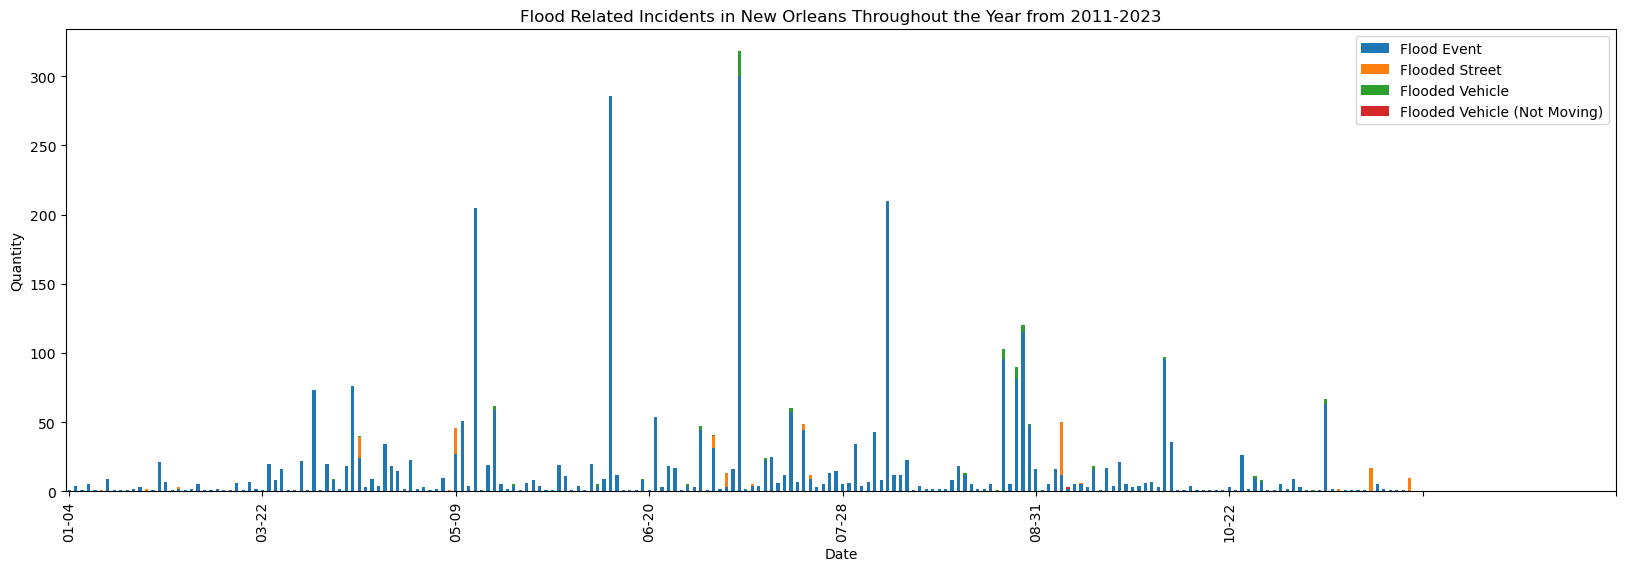

In [131]:
ax = floods_nested_df.unstack().plot(kind = "bar", stacked = True, figsize = (20,6))
xtick_interval = 30
ax.set_xticks(range(0, len(floods_nested_df), xtick_interval));
ax.set_ylabel("Quantity")
ax.set_title("Flood Related Incidents in New Orleans Throughout the Year from 2011-2023")
ax.legend(["Flood Event", "Flooded Street", "Flooded Vehicle", "Flooded Vehicle (Not Moving)"]);

Obviously, the presence of flooding is clearly related to the presence of weather events. However, while there seems to be a broader increase of flooding related events towards the summer when the rain increases, it is very sporadic and fragmented which cannot be explained by seasonal changes alone. It is more likely that these spikes are caused by individual weather events such as storms, that exist within the broader seasonal trends.

In [103]:
output_notebook()
palette = ["#053061", "#67001f"]
TypeText = sorted(filtered_df.TypeText.unique())
MARKERS = ['hex', 'circle_x', 'triangle','star']

police_district = filtered_df['PoliceDistrict']

TITLE = "Police District vs Call Time"
TOOLS = "pan,wheel_zoom,box_zoom,reset,save"

u = figure(tools=TOOLS, toolbar_location="above", width=1200, title=TITLE, x_axis_type="datetime")
u.toolbar.logo = "grey"
u.background_fill_color = "#efefef"
u.xaxis.axis_label = "Police District"
u.yaxis.axis_label = "Call Time"
u.grid.grid_line_color = "white"

source = ColumnDataSource(filtered_df)

u.scatter("TimeCreate", "PoliceDistrict", source=source,
          legend_group="TypeText", fill_alpha=0.4, size=12,
          marker=factor_mark('TypeText', MARKERS, TypeText),
          color=factor_cmap('TypeText', 'Category10_4', TypeText))

show(u)

Loading BokehJS ...

## Closing Thoughts and Final Goals
------
Lorem Ipsum